In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from __future__ import print_function
from collections import OrderedDict

import os
import sys
import timeit
import pickle

import scipy.io as sio
import numpy as np
import theano
import theano.tensor as T

#add the path of Folder Model
sys.path.insert(0, "/home/cwhuang/DVTL/Model/")
import nnet as nn
import criteria	as er
import util
import VANN

import TwinMoonFeaturePlot as fp

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: invalid argument)


number of minibatch at one epoch: 10, batch size source : 100, target : 100 
 validation size, S:600, T:600, test size, S:400, T:400
... building the model
Encoder1_share is constructed with hidden layer number 0
Encoder1_mu is constructed with hidden layer number 0
Encoder1_sigma is constructed with hidden layer number 0
Encoder3_pi is constructed with hidden layer number 1
Encoder2_share is constructed with hidden layer number 0
Encoder2_mu is constructed with hidden layer number 0
Encoder2_sigma is constructed with hidden layer number 0
Decoder1_share is constructed with hidden layer number 0
Decoder1_mu is constructed with hidden layer number 0
Decoder1_sigma is constructed with hidden layer number 0
Decoder2_share is constructed with hidden layer number 0
Decoder2_mu is constructed with hidden layer number 0
Decoder2_sigma is constructed with hidden layer number 0
DomainClassifier is constructed with hidden layer number 1
Encoder1_share is constructed with hidden layer number 0
En

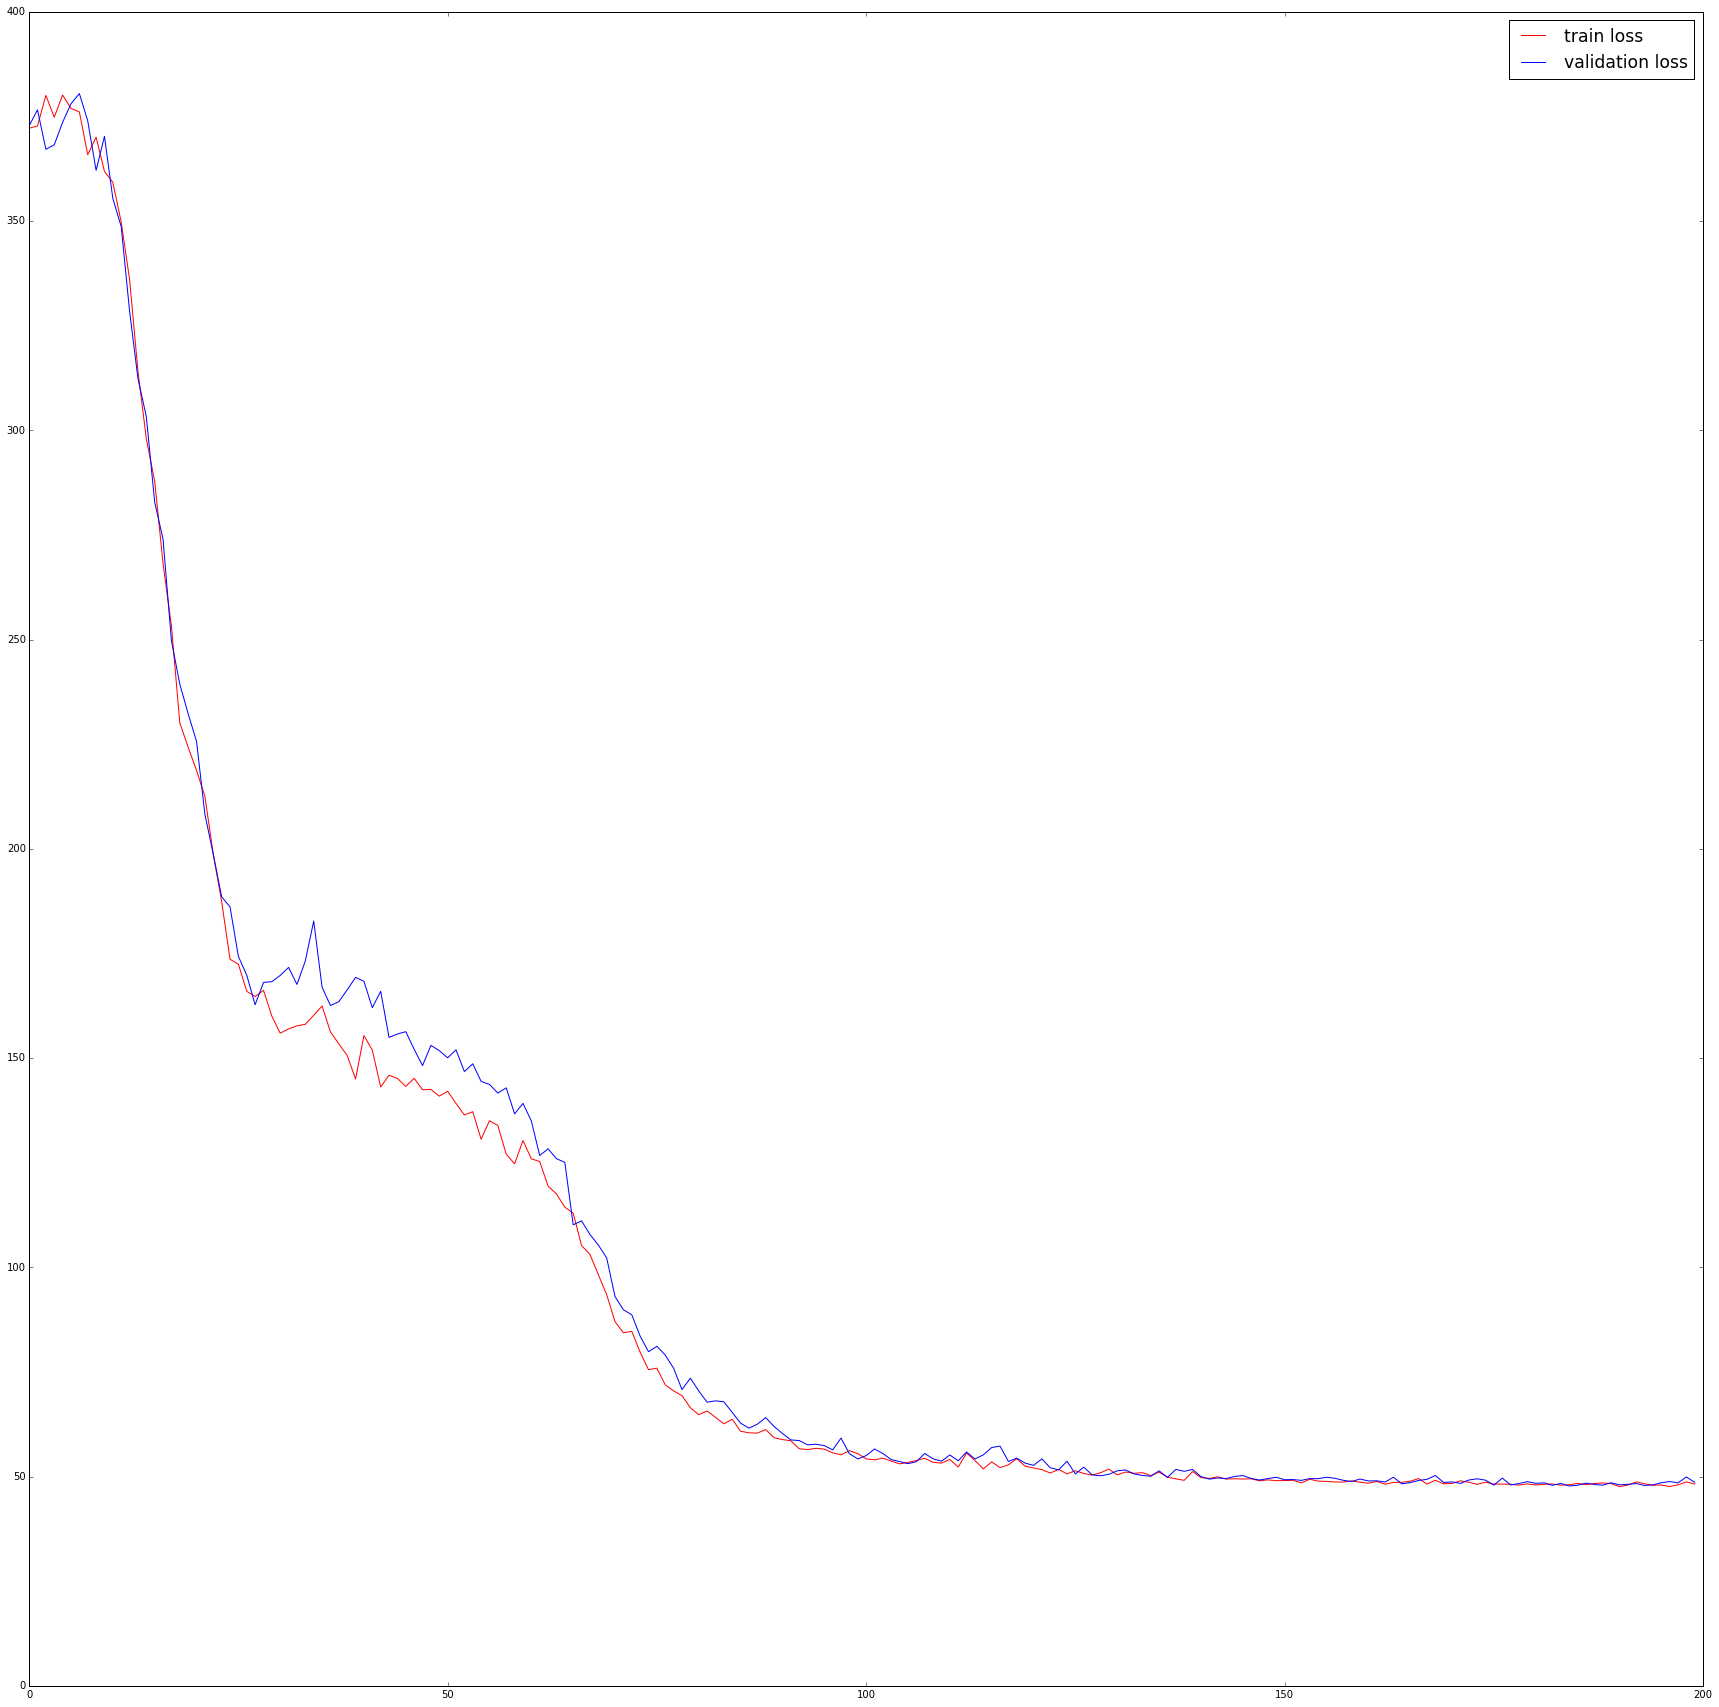

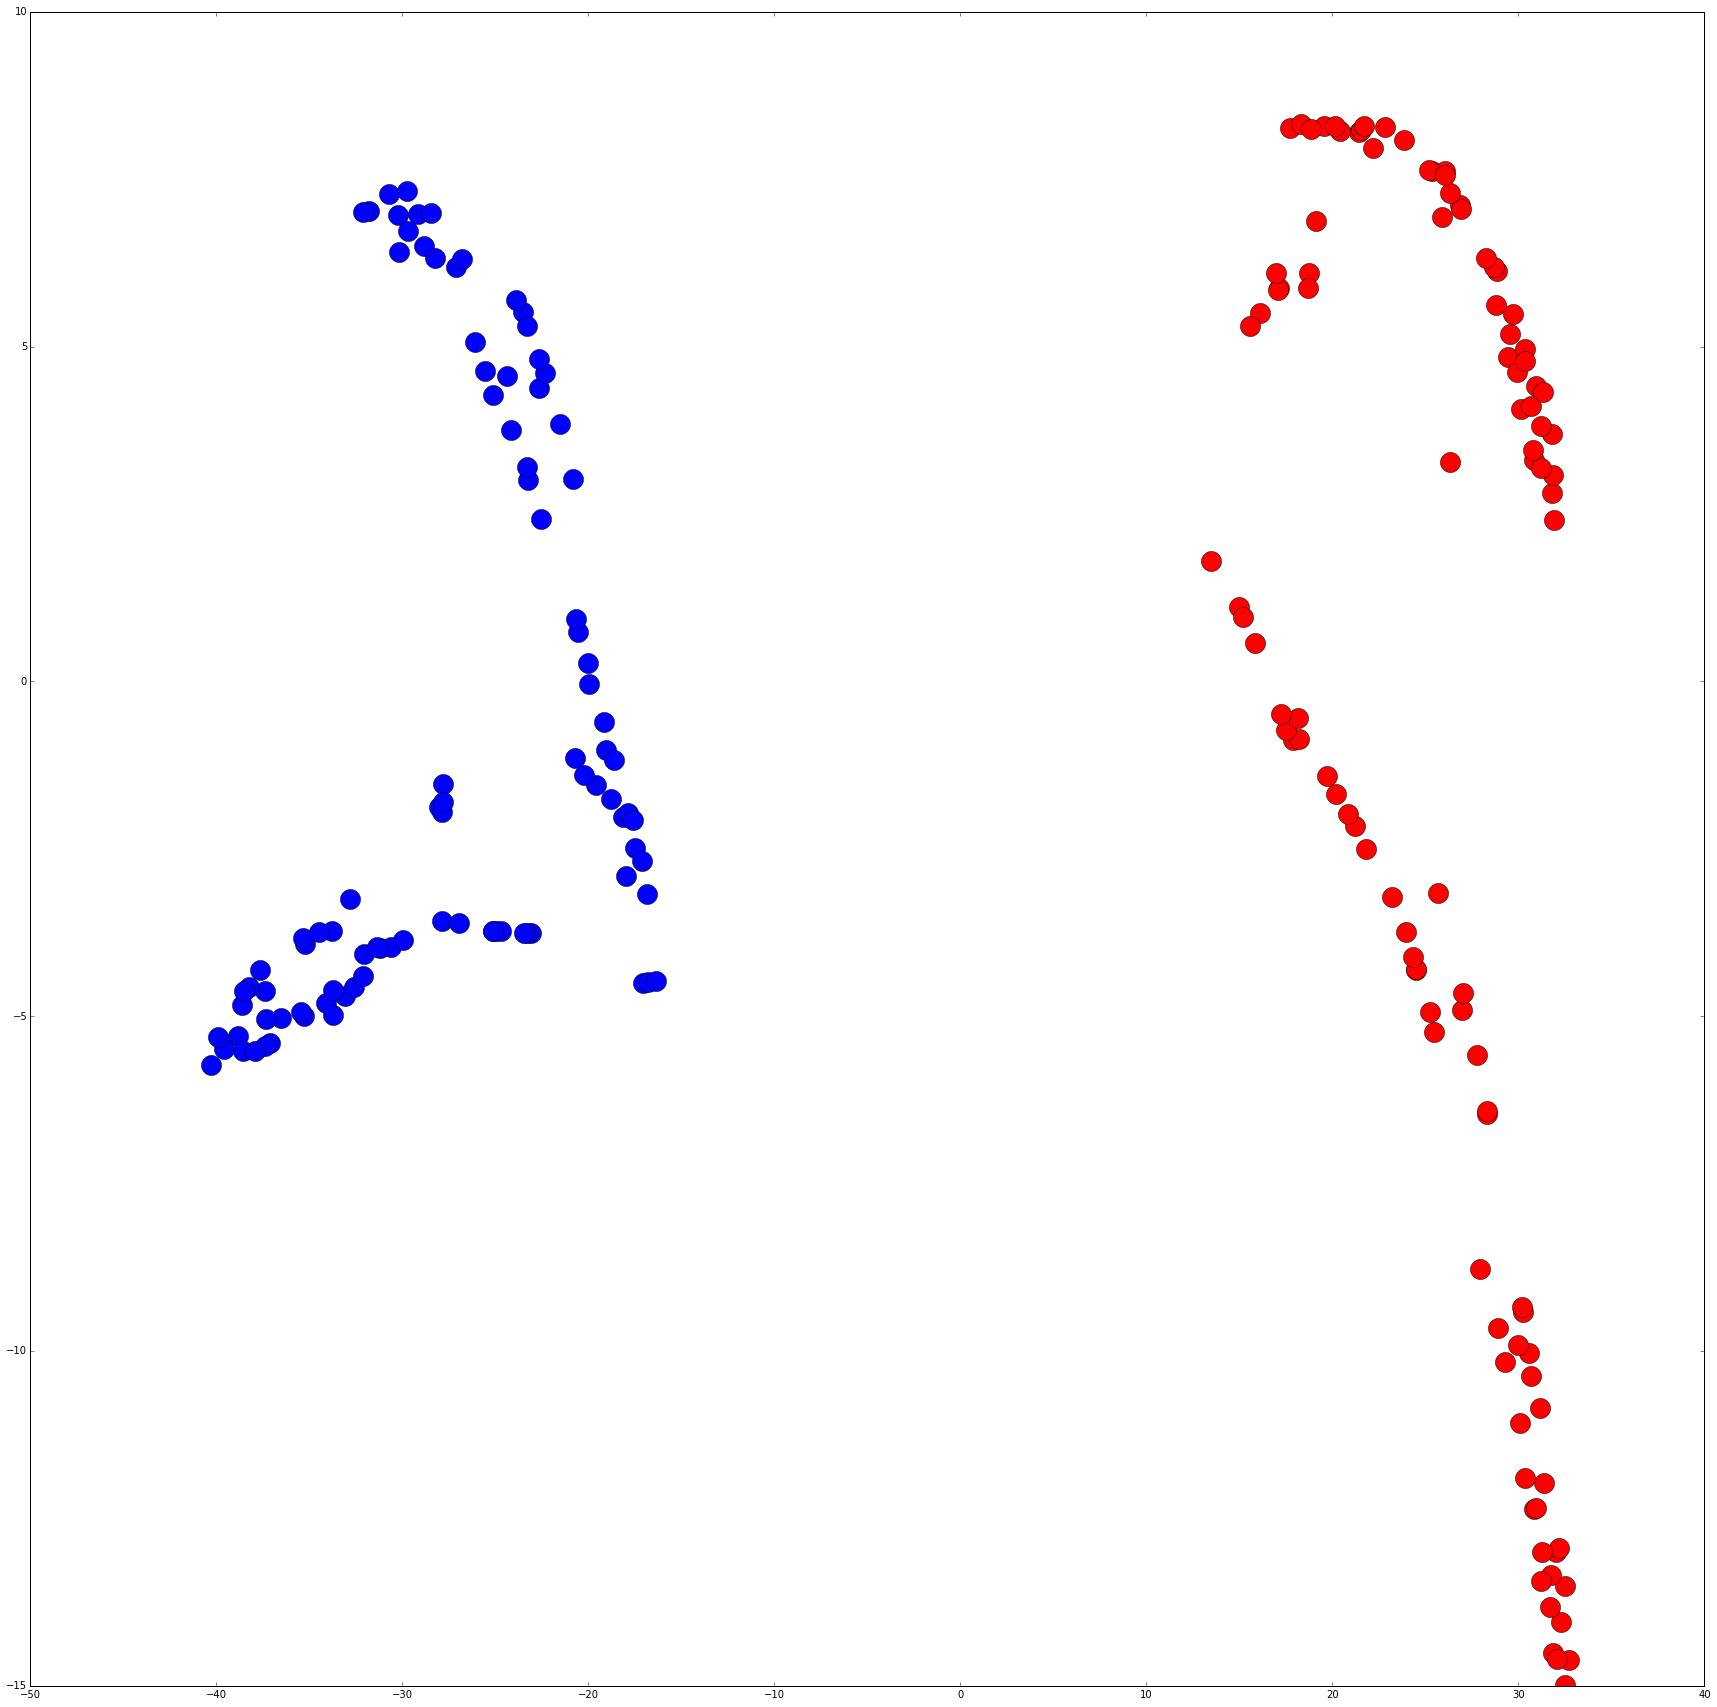

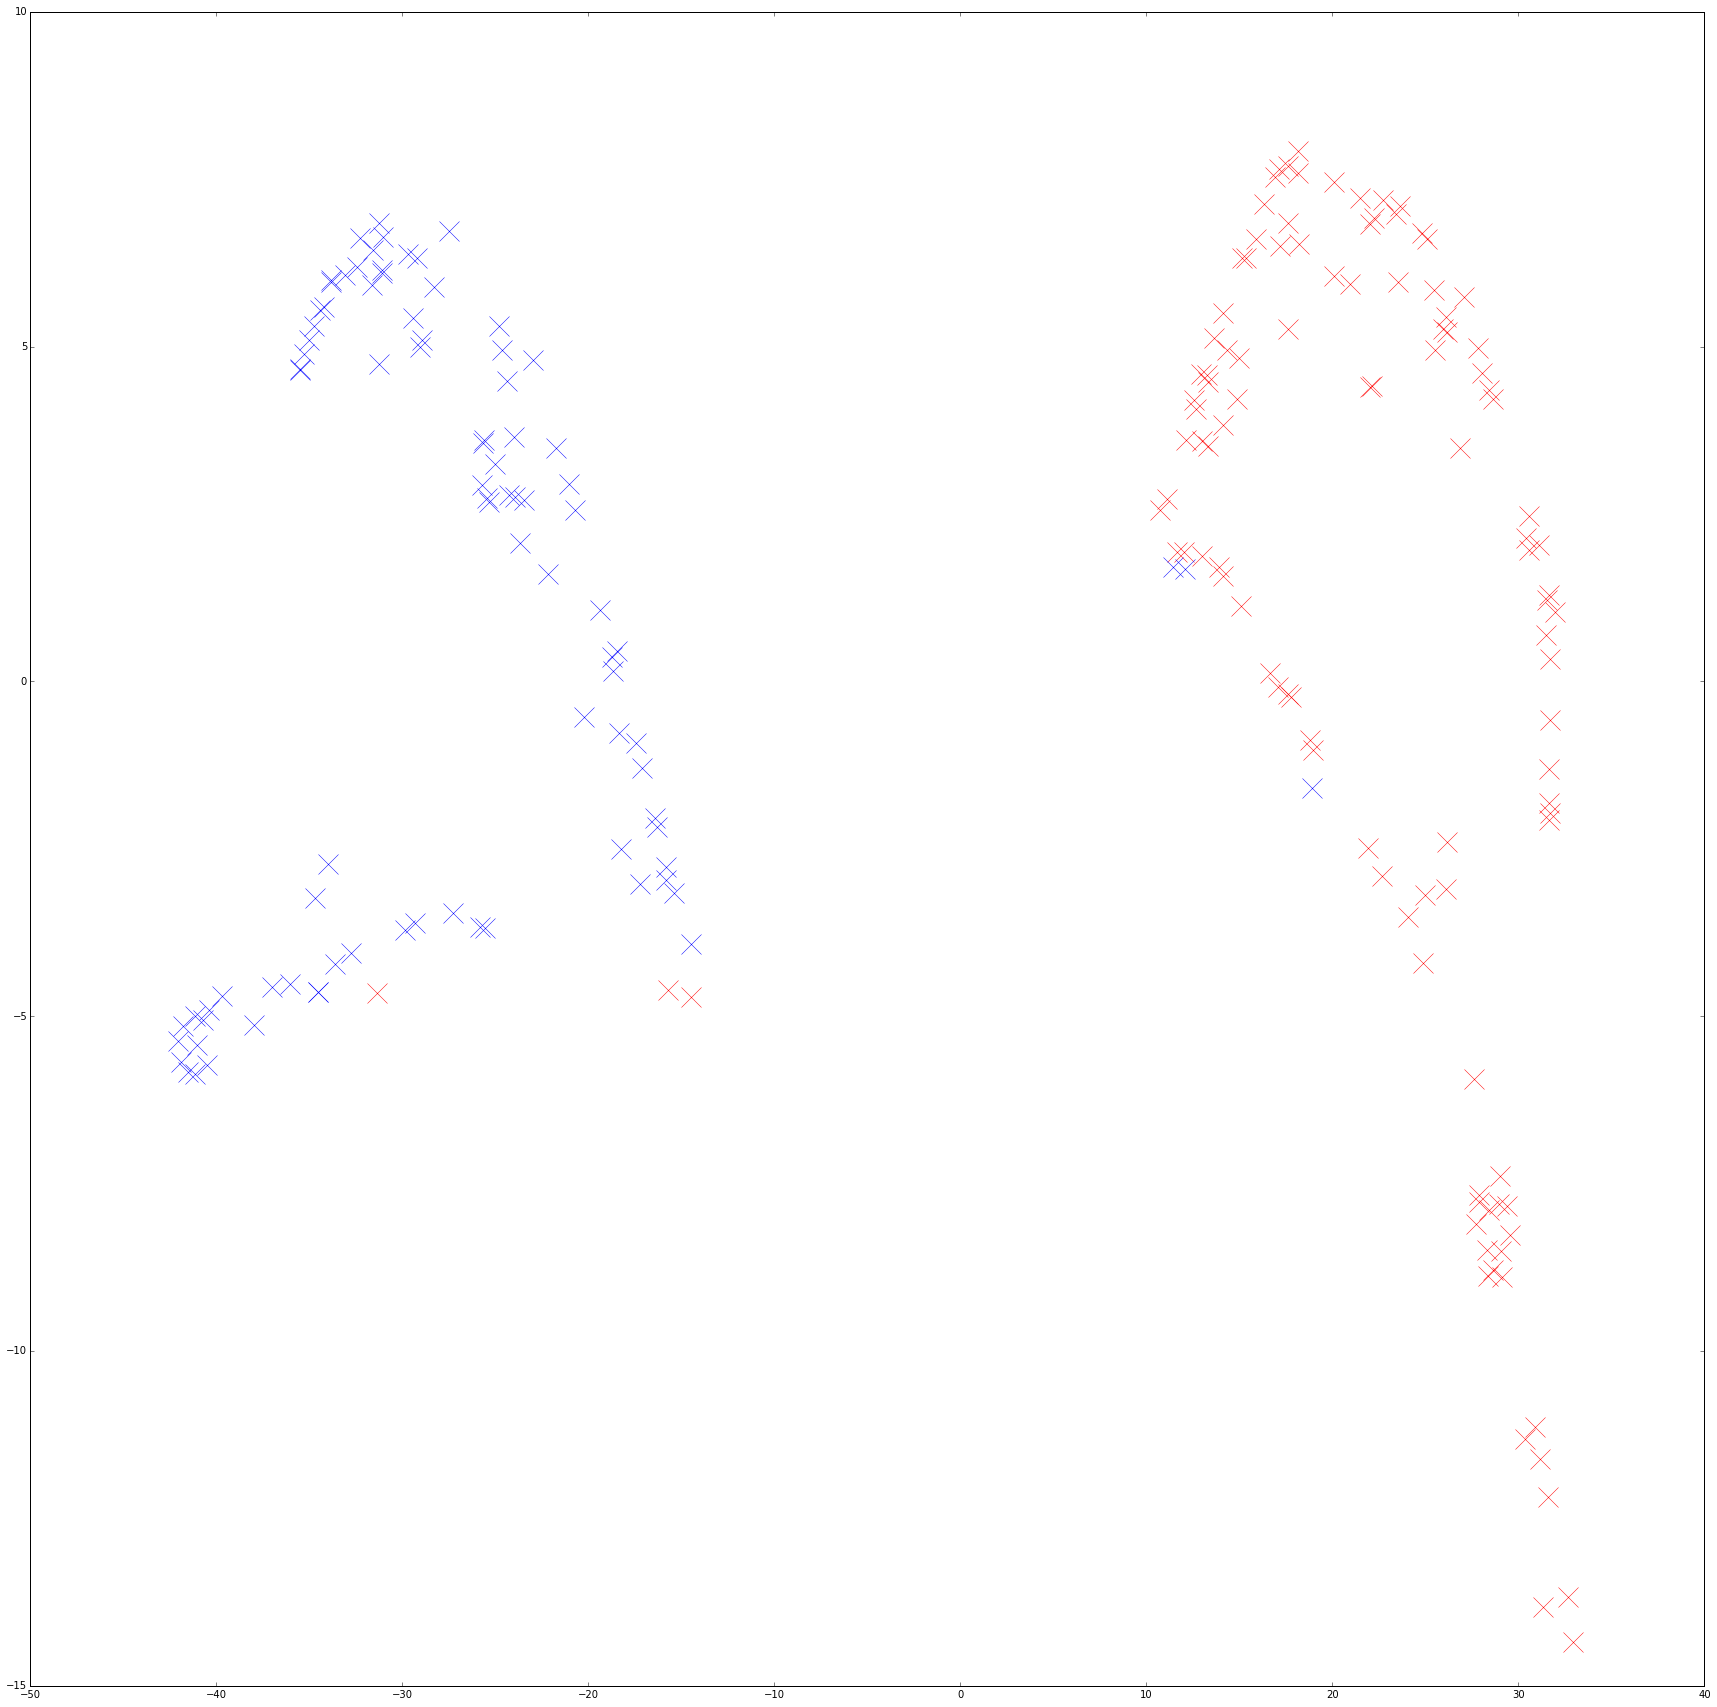

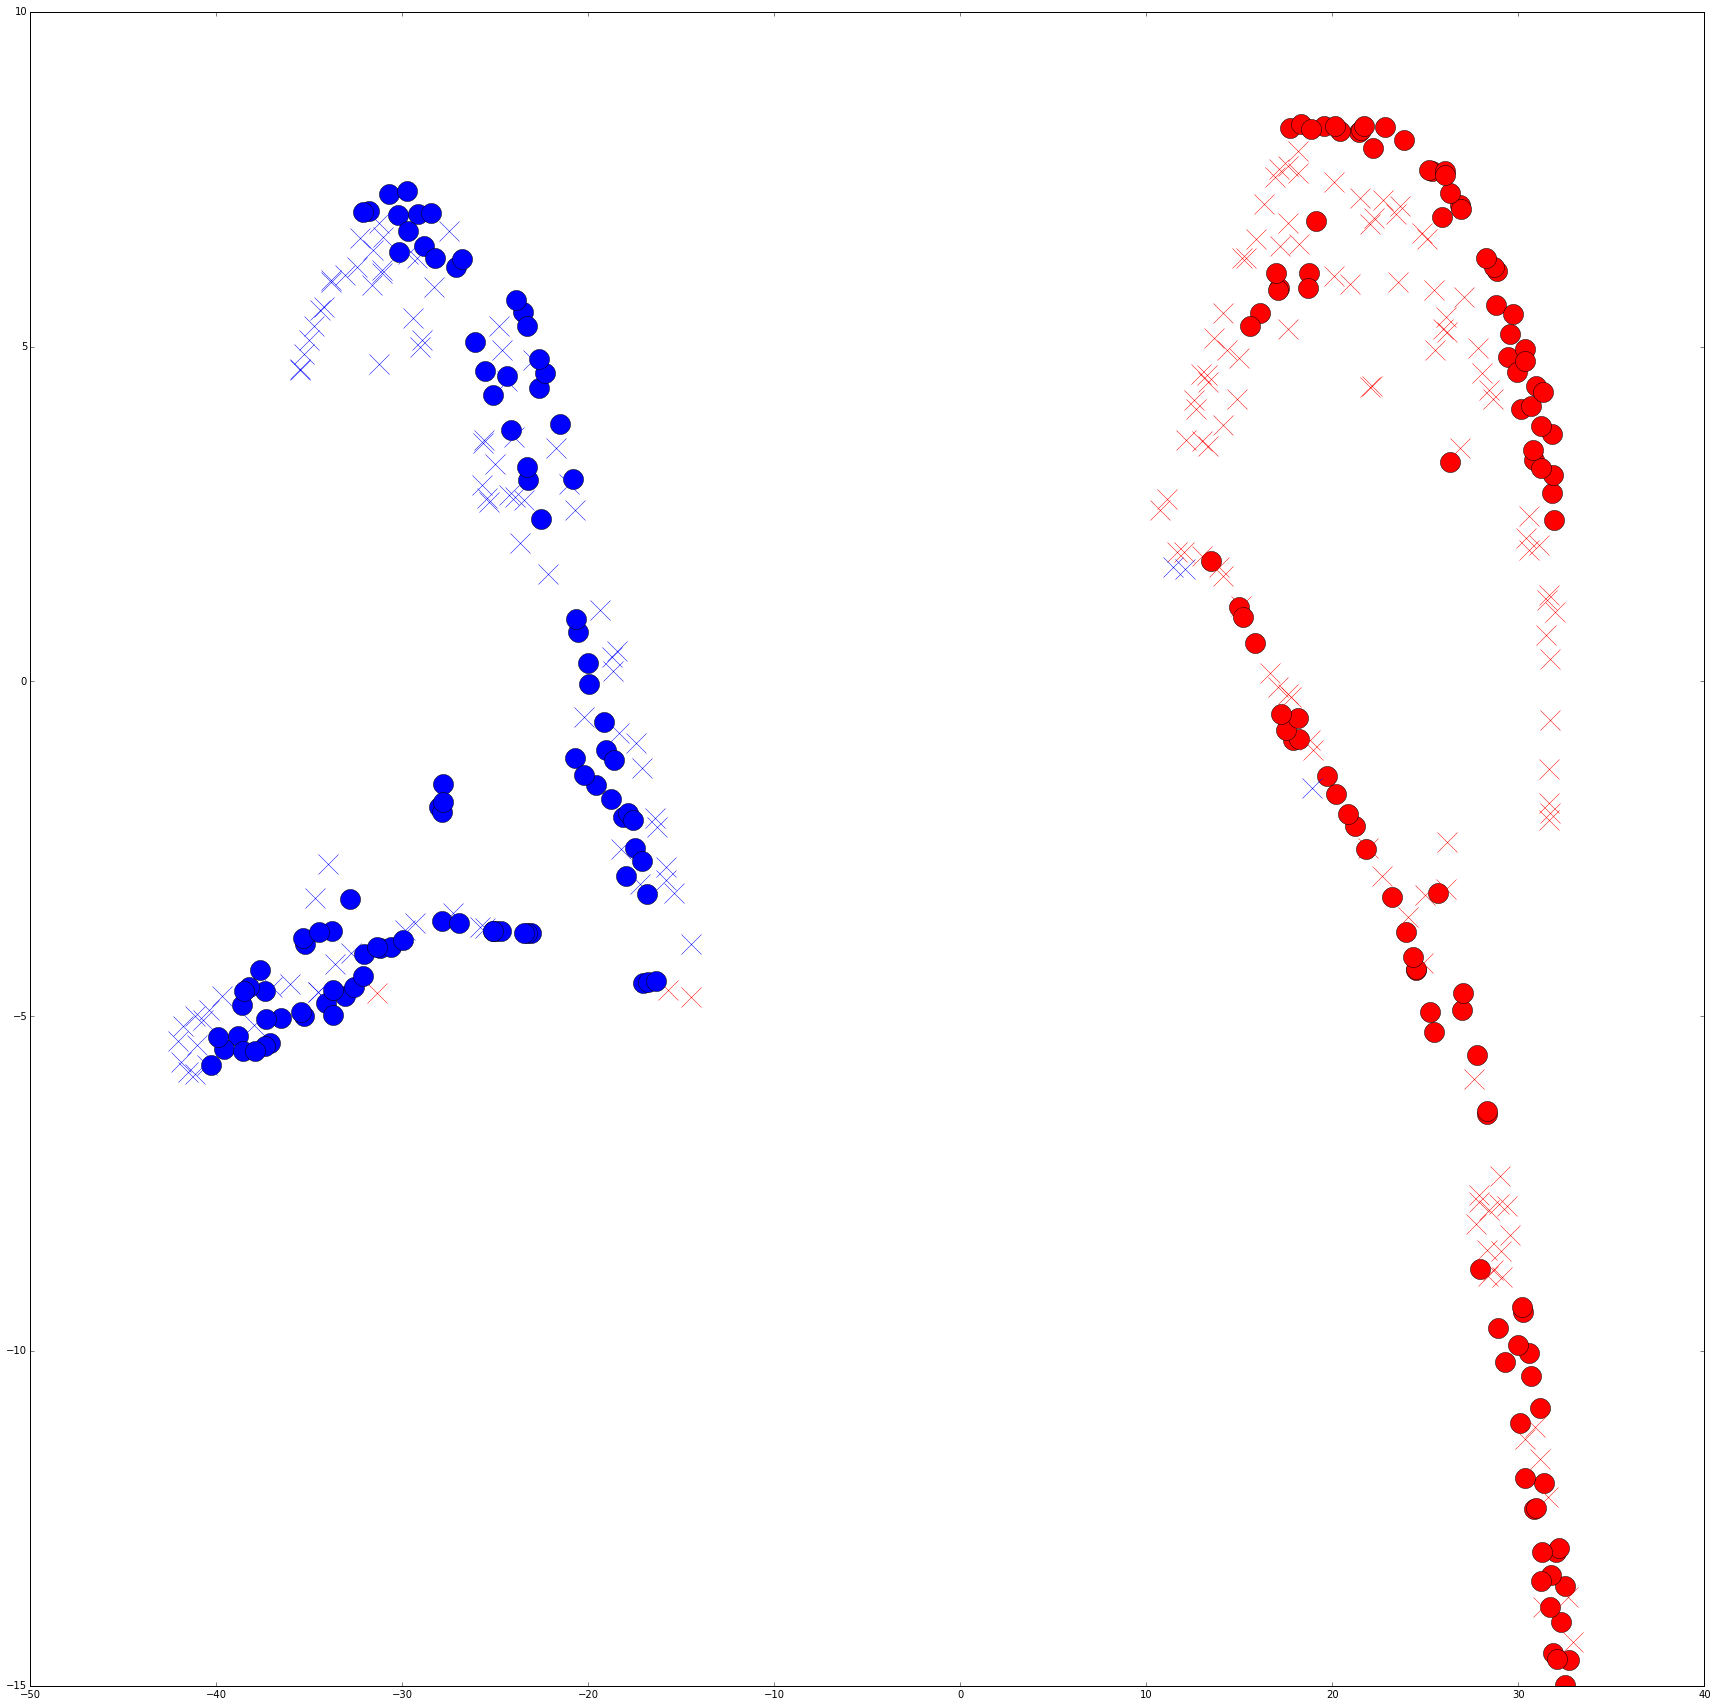

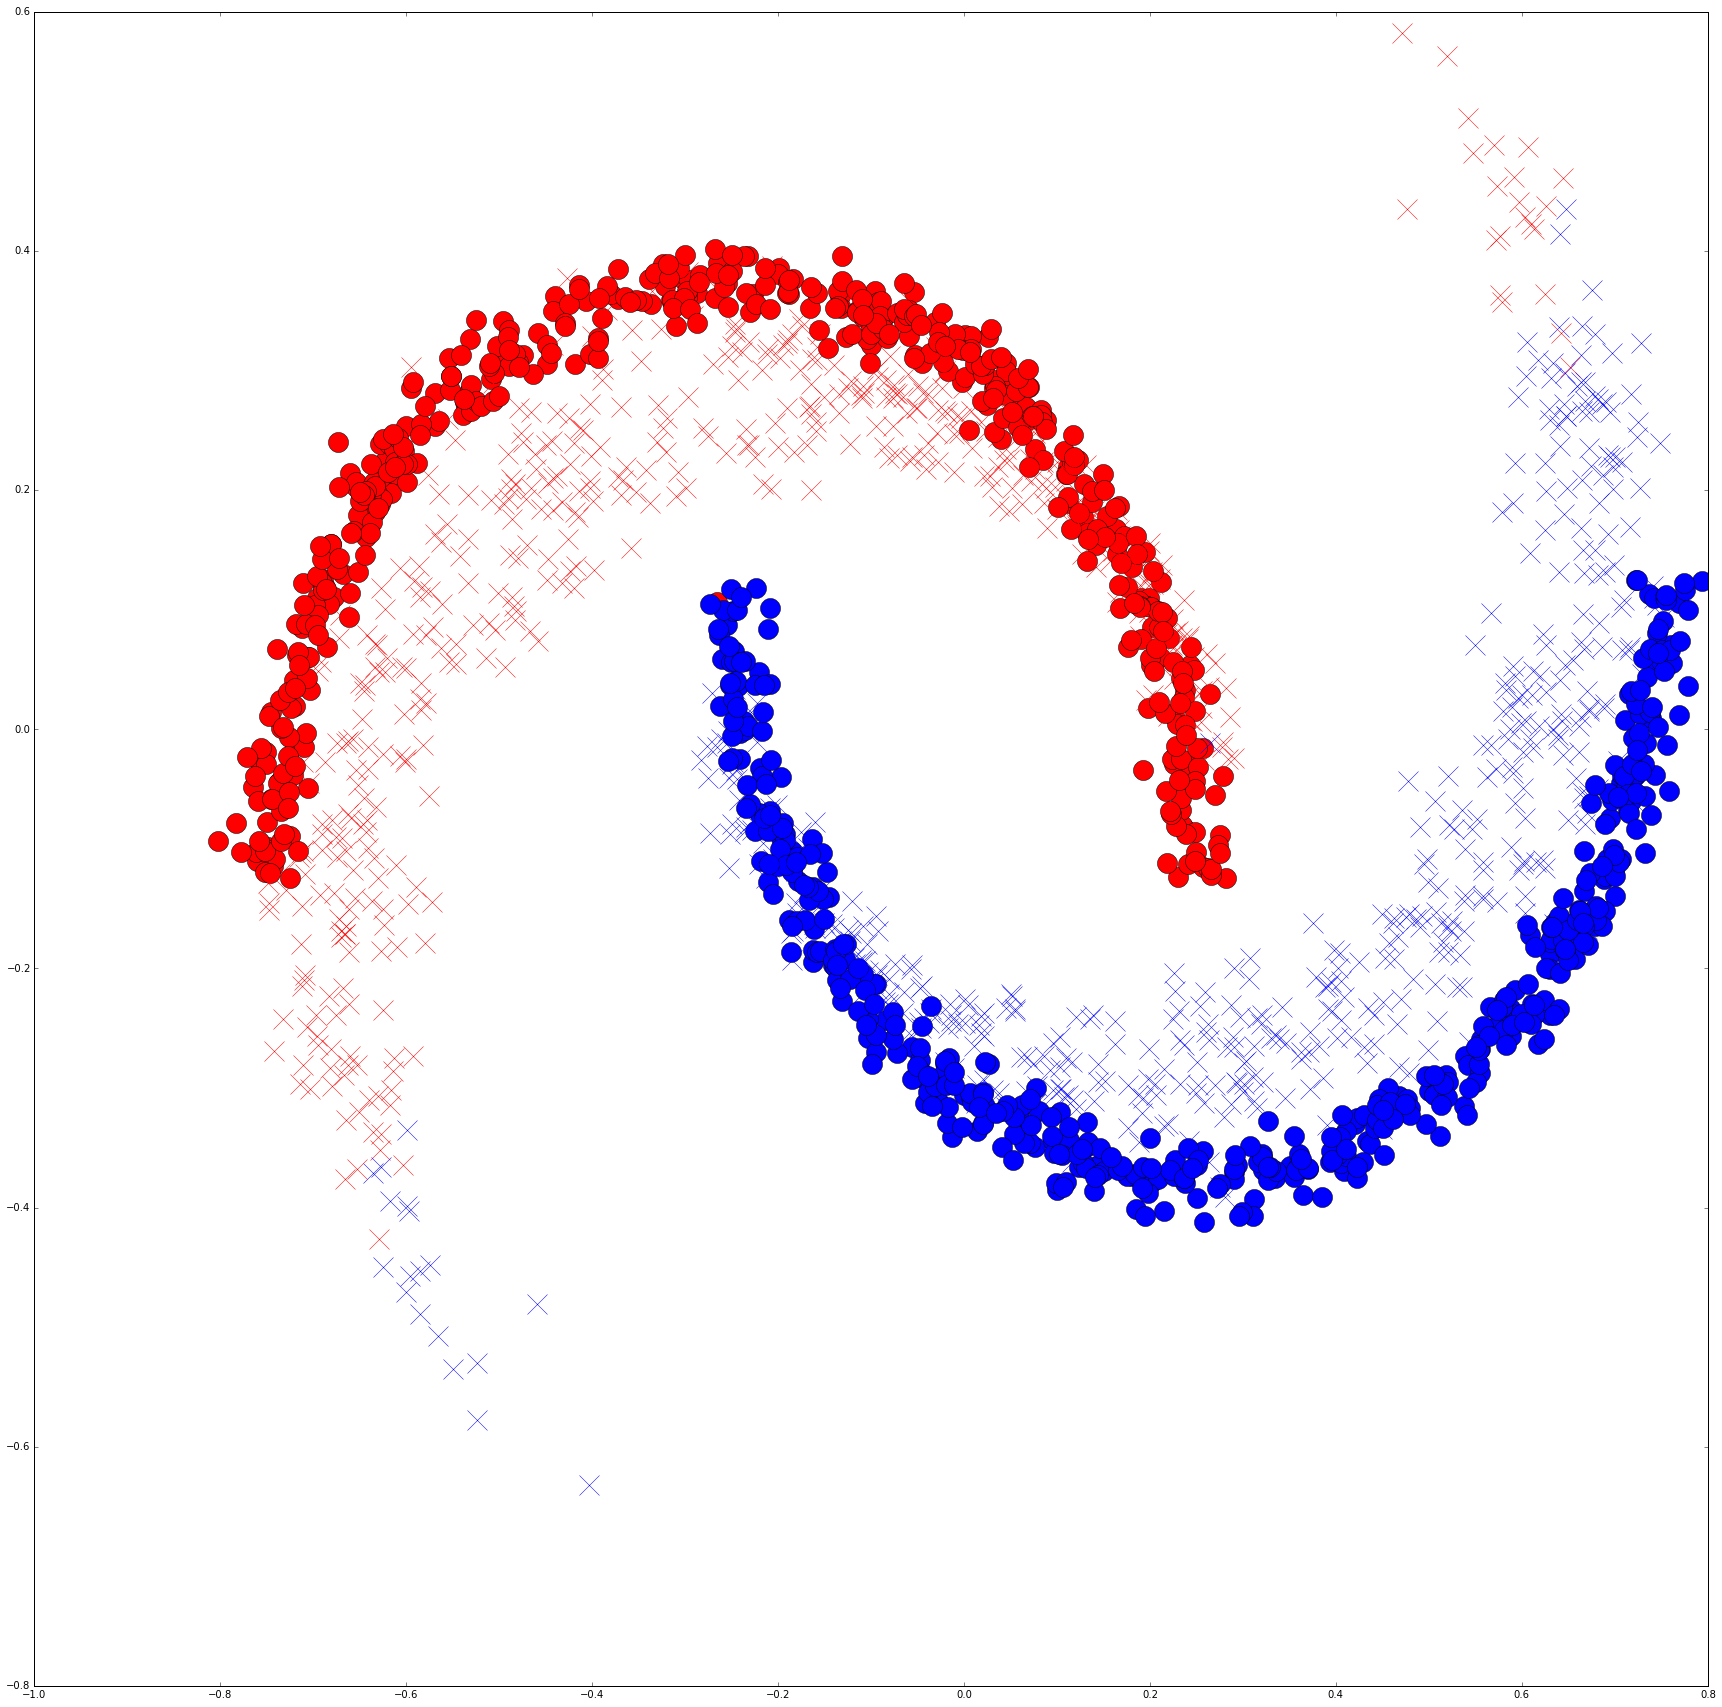

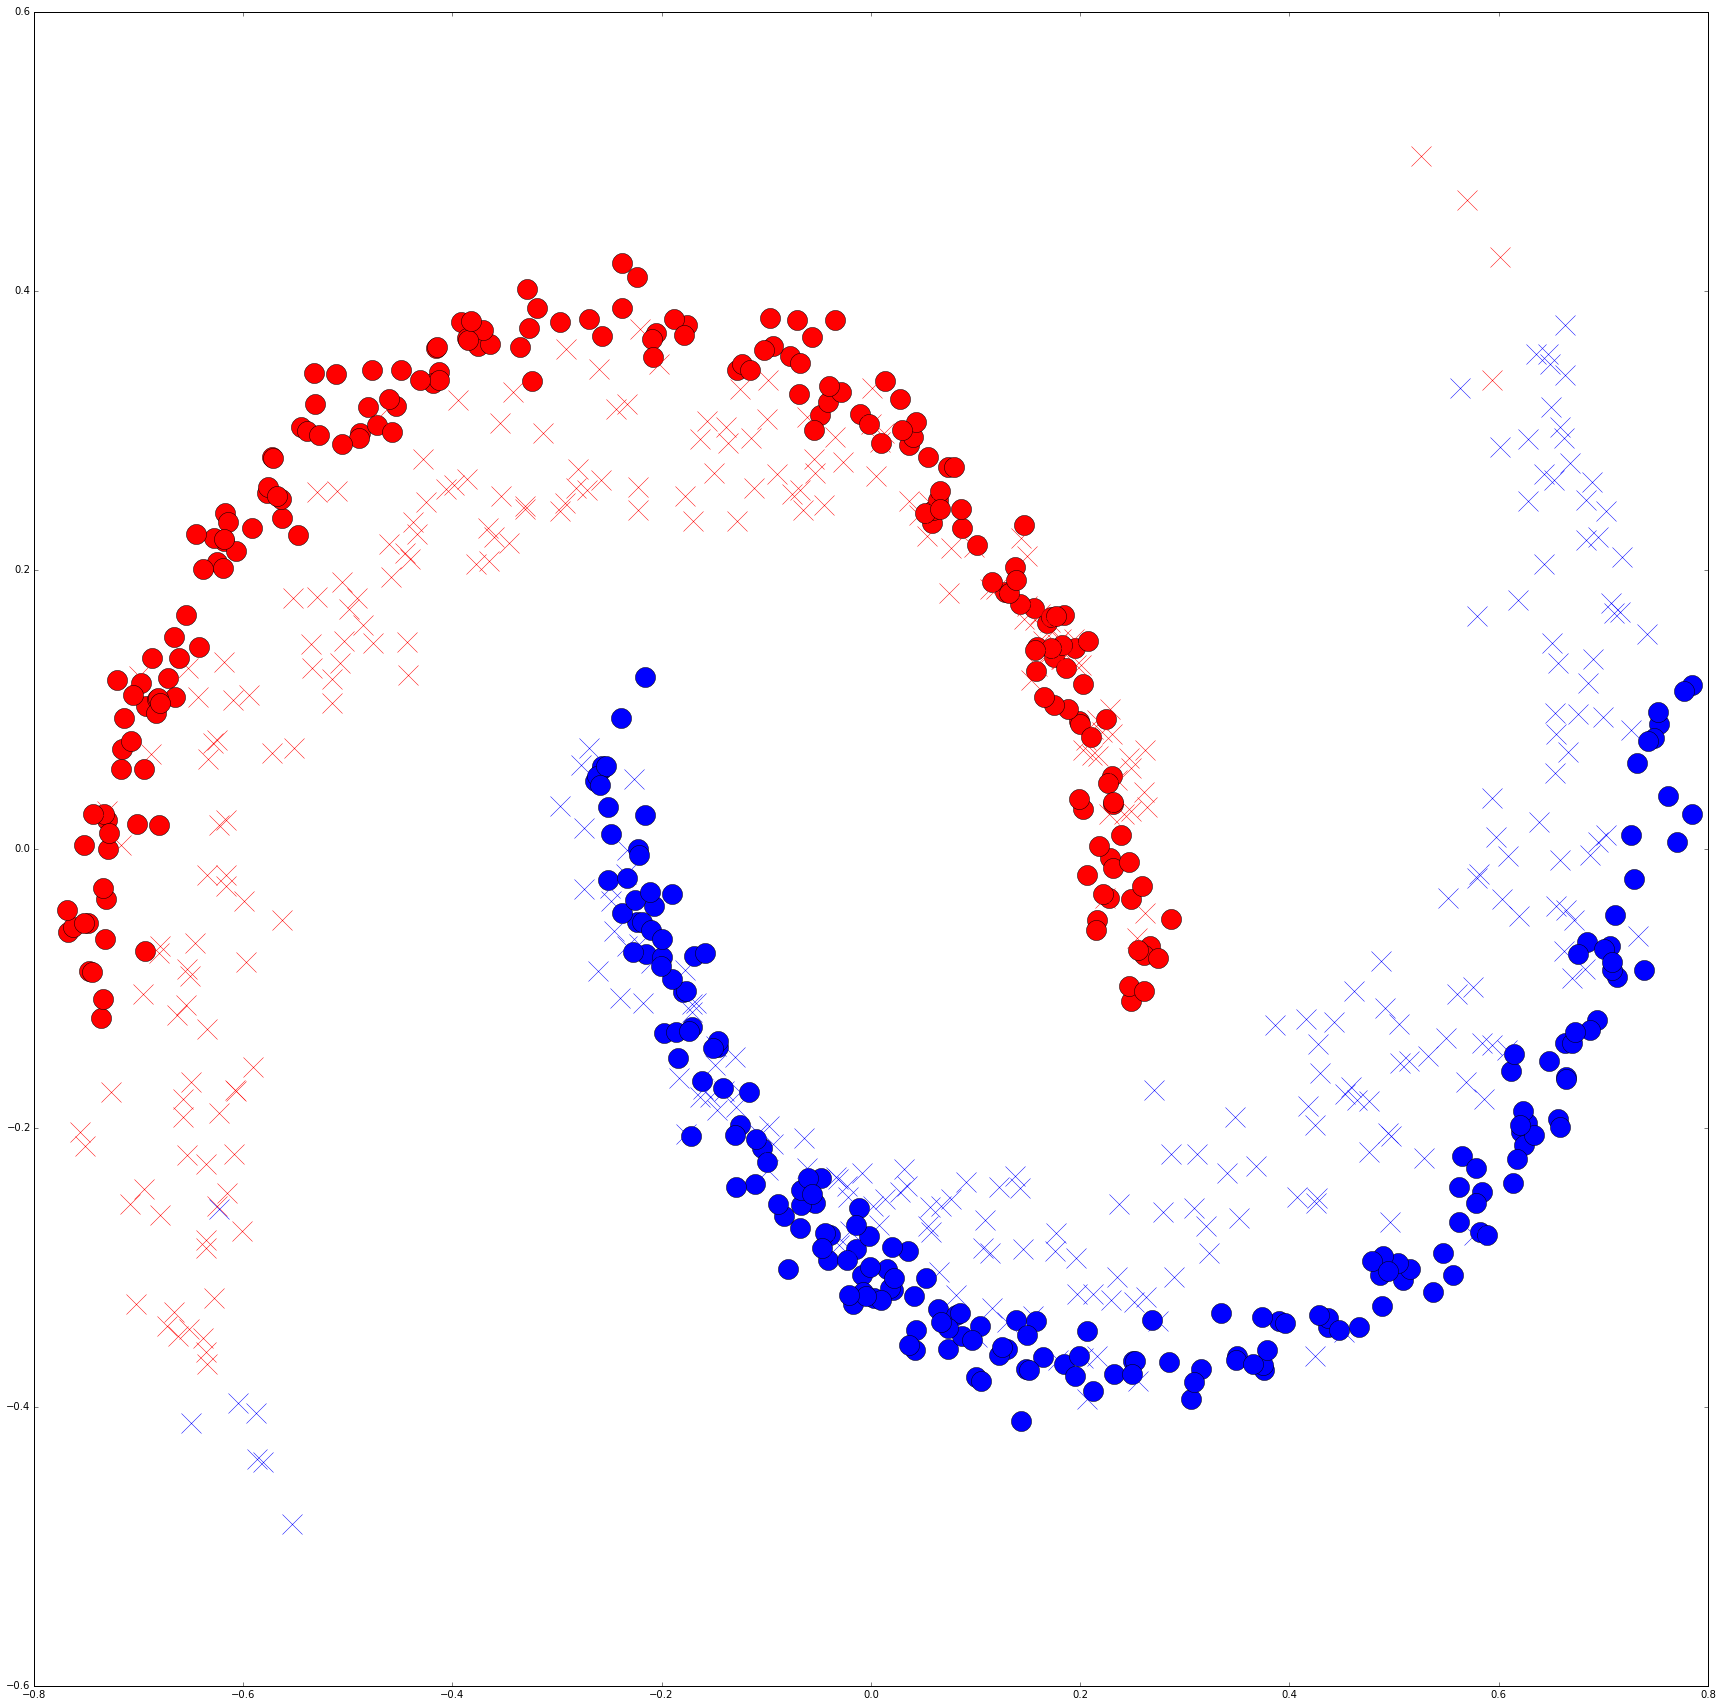

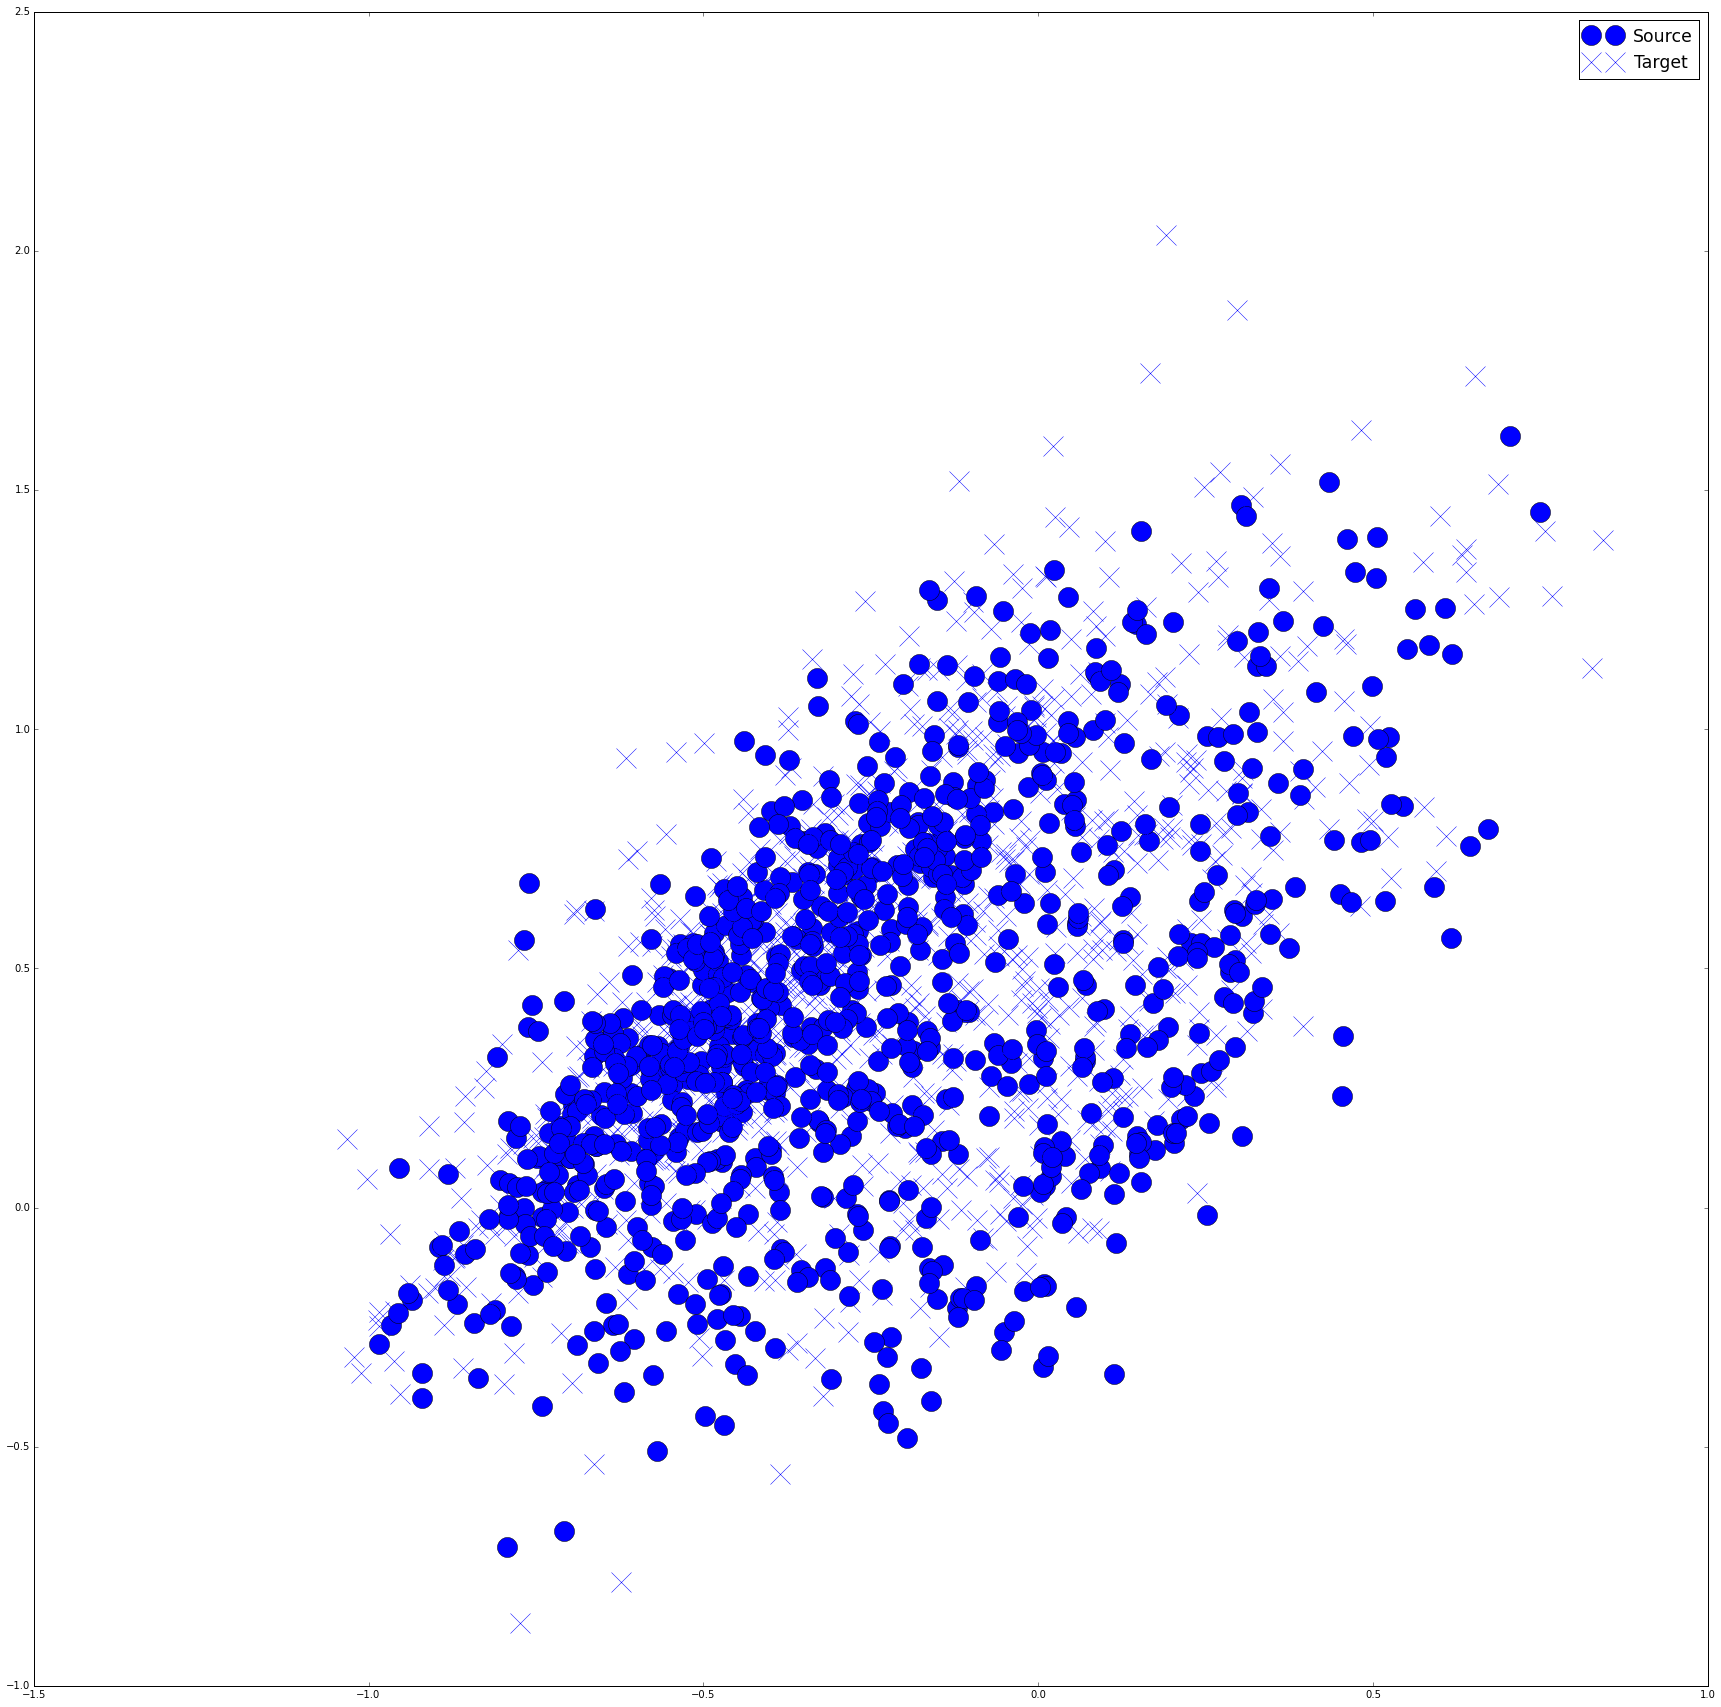

In [2]:
'''Model Construct'''
if __name__ == '__main__':
    
    file = '/home/cwhuang/DVTL/Dataset/Synthetic_Data/Twin_moon.npy'
    data = np.load(file)
    
    train_fts_source, train_labels_source = data[0]
    valid_fts_source, valid_labels_source = data[1]
    test_fts_source, test_labels_source = data[2]
    
    train_fts_target, train_labels_target = data[3]
    valid_fts_target, valid_labels_target = data[4]
    test_fts_target, test_labels_target = data[5]
    
    source_data = [(train_fts_source, train_labels_source), (valid_fts_source, valid_labels_source), (test_fts_source, test_labels_source)]
    target_data = [(train_fts_target, train_labels_target), (valid_fts_target, valid_labels_target), (test_fts_target, test_labels_target)]   
    
    ########################################################################
    ###                        Coefficient Initial                       ###
    ########################################################################           

    x_dim = 2
    y_dim = 2    
    d_dim = 2    
    z_dim = 10                #dimension of latent feature
    a_dim = 5                 #dimension of prior of latent feature    
    h_zy_dim = 10             #dimension of hidden unit  
    h_ay_dim = 10
    h_y_dim = 10  
    learning_rate = 0.01
    activation = T.nnet.sigmoid

    struct = VANN.VANN_struct()    
    encoder_template = nn.NN_struct()

    
    struct.encoder1.share.layer_dim = [x_dim+d_dim, h_zy_dim]
    struct.encoder1.share.activation = [activation]
    struct.encoder1.share.learning_rate = [learning_rate, learning_rate]
    struct.encoder1.share.decay = [1, 1]                

    struct.encoder1.mu.layer_dim = [h_zy_dim, z_dim]
    struct.encoder1.mu.activation = [None]
    struct.encoder1.mu.learning_rate = [learning_rate, learning_rate]
    struct.encoder1.mu.decay = [1, 1]      
    struct.encoder1.sigma.layer_dim = [h_zy_dim, z_dim]
    struct.encoder1.sigma.activation = [None]
    struct.encoder1.sigma.learning_rate = [learning_rate, learning_rate]
    struct.encoder1.sigma.decay = [1, 1]   
    
    struct.encoder2.share.layer_dim = [z_dim+y_dim, h_ay_dim]
    struct.encoder2.share.activation = [ activation]
    struct.encoder2.share.learning_rate = [learning_rate, learning_rate]
    struct.encoder2.share.decay = [1, 1]                
    struct.encoder2.mu.layer_dim = [h_ay_dim, a_dim]
    struct.encoder2.mu.activation = [None]
    struct.encoder2.mu.learning_rate = [learning_rate, learning_rate]
    struct.encoder2.mu.decay = [1, 1]      
    struct.encoder2.sigma.layer_dim = [h_ay_dim, a_dim]
    struct.encoder2.sigma.activation = [None]
    struct.encoder2.sigma.learning_rate = [learning_rate, learning_rate]
    struct.encoder2.sigma.decay = [1, 1]
    
    
    struct.encoder3.layer_dim = [z_dim, h_y_dim, y_dim]
    struct.encoder3.activation = [activation, T.nnet.softmax]   
    struct.encoder3.learning_rate = [learning_rate, learning_rate]
    struct.encoder3.decay = [1, 1]     
    '''
    
    struct.encoder3.layer_dim = [z_dim, y_dim]
    struct.encoder3.activation = [ T.nnet.softmax]   
    struct.encoder3.learning_rate = [learning_rate, learning_rate]
    struct.encoder3.decay = [1, 1]     
    '''
    
    struct.decoder1.share.layer_dim = [z_dim+d_dim, h_zy_dim]
    struct.decoder1.share.activation = [activation]
    struct.decoder1.share.learning_rate = [learning_rate, learning_rate]
    struct.decoder1.share.decay = [1, 1]                
    struct.decoder1.mu.layer_dim = [h_zy_dim, x_dim]
    struct.decoder1.mu.activation = [None]
    struct.decoder1.mu.learning_rate = [learning_rate, learning_rate]
    struct.decoder1.mu.decay = [1, 1]      
    struct.decoder1.sigma.layer_dim = [h_zy_dim, x_dim]
    struct.decoder1.sigma.activation = [None]
    struct.decoder1.sigma.learning_rate = [learning_rate, learning_rate]
    struct.decoder1.sigma.decay = [1, 1]      
    
    struct.decoder2.share.layer_dim = [a_dim+y_dim, h_ay_dim]
    struct.decoder2.share.activation = [activation]
    struct.decoder2.share.learning_rate = [learning_rate, learning_rate]
    struct.decoder2.share.decay = [1, 1]                
    struct.decoder2.mu.layer_dim = [h_ay_dim, z_dim]
    struct.decoder2.mu.activation = [None]
    struct.decoder2.mu.learning_rate = [learning_rate, learning_rate]
    struct.decoder2.mu.decay = [1, 1]      
    struct.decoder2.sigma.layer_dim = [h_ay_dim, z_dim]
    struct.decoder2.sigma.activation = [None]
    struct.decoder2.sigma.learning_rate = [learning_rate, learning_rate]
    struct.decoder2.sigma.decay = [1, 1]       
    
    struct.DomainClassifier.layer_dim = [z_dim, 5, d_dim]
    struct.DomainClassifier.activation = [activation, T.nnet.softmax]   
    struct.DomainClassifier.learning_rate = [learning_rate, learning_rate]
    struct.DomainClassifier.decay = [1, 1]      
    
    coef = VANN.VANN_coef(
        alpha = 1000,
        beta = 1000,        
        L = 1,
        optimize = 'Adam_update'  
    )     
               
    description = 'TwinMoon_VANN_%s' % (coef.optimize)    
        
    features_model, test_model, trained_param = VANN.VANN_training(
        source_data = source_data,
        target_data = target_data,
        n_train_batches = 10,
        n_epochs = 200,
        k = 5,
        struct = struct,
        coef = coef,
        description = description
    )
    
    sample_n = 200
    fp.features_plot(features_model, test_model, source_data, target_data, sample_n, description, reconstruction=True)    